<a href="https://colab.research.google.com/github/brianfarrelly/final_capstone/blob/master/bacterial_pneumonia_xrays_robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd

from google.colab import drive


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [3]:
print(tf.__version__)

2.2.0


In [4]:
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DATASET_DIR = "/content/gdrive/My Drive/data/corona_normal_bacterial/"

In [6]:
os.listdir(DATASET_DIR)


['train',
 'test',
 'bacmodel.h5',
 'tfbacmodel.h5',
 'revisedbacmodel.h5',
 'epochs',
 'latestbacmodel.h5',
 'robustbacmodel.h5']

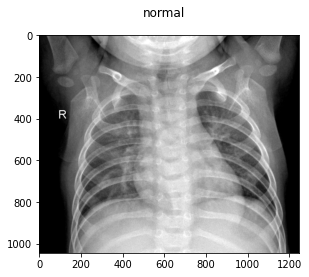

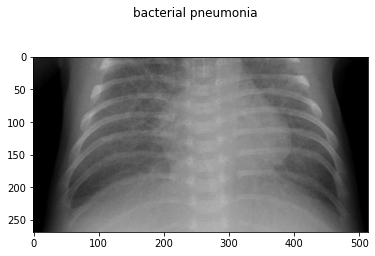

In [7]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(DATASET_DIR + '/train/normal/*'):
    normal_images.append(mpimg.imread(img_path))
    break

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(DATASET_DIR + '/train/bacterial/*'):
    covid_images.append(mpimg.imread(img_path))
    break

fig = plt.figure()
fig.suptitle('bacterial pneumonia')
plt.imshow(covid_images[0], cmap='gray') 

In [0]:
IMG_W = 400
IMG_H = 400
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 48
BATCH_SIZE = 6

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))

#model.add(Dense(2))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 398, 398, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 197, 197, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        1

In [0]:
DATASET_DIR = "/content/gdrive/My Drive/data/corona_normal_bacterial/"

In [12]:
print(DATASET_DIR)

/content/gdrive/My Drive/data/corona_normal_bacterial/


In [13]:
os.listdir(DATASET_DIR)


['train',
 'test',
 'bacmodel.h5',
 'tfbacmodel.h5',
 'revisedbacmodel.h5',
 'epochs',
 'latestbacmodel.h5',
 'robustbacmodel.h5']

In [14]:
import os, os.path
DIR = DATASET_DIR + "/train/normal/"

path, dirs, files = next(os.walk(DIR))
file_count = len(files)
print(file_count)

1300


In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



In [16]:
train_generator = train_datagen.flow_from_directory(
    directory=DATASET_DIR + "/train/",
    target_size=(IMG_W, IMG_H),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    directory=DATASET_DIR + "/train/",
    target_size=(IMG_W, IMG_H),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    directory=DATASET_DIR + "/test/",
    target_size=(IMG_W, IMG_H),
    color_mode="rgb",
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=42
)


Found 2080 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 400 images belonging to 2 classes.




---


---



---



---



---

Tensorboard



---



---



---



---



---



---



In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
%tensorboard --logdir logs

In [0]:
import tensorflow as tf
import datetime, os

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [0]:
history = model.fit(
    train_generator,
    steps_per_epoch = 4,
    epochs = 50,
    callbacks=[tensorboard_callback])




---



---



---



---

Save model by Epochs.

---



---



---



---



---



In [21]:
print(DATASET_DIR)

/content/gdrive/My Drive/data/corona_normal_bacterial/


In [0]:
from tensorflow.keras.callbacks import *

DATASET_DIR

filepath = DATASET_DIR + "epochs/epochs:{epoch:03d}-accuracy:{accuracy:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoint]



---



---



---



---



---



---



---



In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [25]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 32,
    validation_data = valid_generator, 
    validation_steps = 16,
    epochs = 100,
    callbacks=callbacks_list
    )

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5918
Epoch 00001: saving model to /content/gdrive/My Drive/data/corona_normal_bacterial/epochs/epochs:001-accuracy:0.592.hdf5
32/32 [==============================] - 487s 15s/step - loss: 0.6735 - accuracy: 0.5918 - val_loss: 0.4322 - val_accuracy: 0.8203
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.7207
Epoch 00002: saving model to /content/gdrive/My Drive/data/corona_normal_bacterial/epochs/epochs:002-accuracy:0.721.hdf5
32/32 [==============================] - 201s 6s/step - loss: 0.5280 - accuracy: 0.7207 - val_loss: 0.2587 - val_accuracy: 0.8965
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.8311
Epoch 00003: saving model to /content/gdrive/My Drive/data/corona_normal_bacterial/epochs/epochs:003-accuracy:0.831.hdf5
32/32 [==============================] - 126s 4s/step - loss: 0.4523 - accuracy: 0.8311 - v

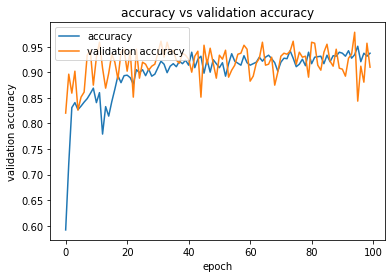

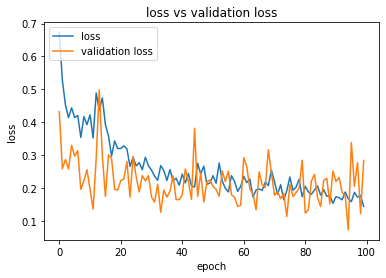

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy vs validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'validation accuracy'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'validation loss'], loc='upper left')
plt.show()

In [27]:
print("loss", history.history['loss'][-1])
print("validation loss", history.history['val_loss'][-1])
print("accuracy", history.history['accuracy'][-1])
print("validation accuracy", history.history['val_accuracy'][-1])


loss 0.14443030953407288
validation loss 0.2840075194835663
accuracy 0.9375
validation accuracy 0.91015625


In [0]:
PATH = '/content/gdrive/My Drive/data/corona/Chest_xray_Corona_Metadata.csv'
meta = pd.read_csv(PATH)

In [21]:
test = meta[meta.Dataset_type == 'TEST']
test = test.fillna(0)
test.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5286,5309,IM-0021-0001.jpeg,Normal,TEST,0,0
5287,5310,IM-0019-0001.jpeg,Normal,TEST,0,0
5288,5311,IM-0017-0001.jpeg,Normal,TEST,0,0
5289,5312,IM-0016-0001.jpeg,Normal,TEST,0,0
5290,5313,IM-0015-0001.jpeg,Normal,TEST,0,0


In [22]:
testpnem = test[test.Label =='Pnemonia']
testpnem.shape

(390, 6)

In [23]:
bac_testpnem = testpnem[testpnem.Label_1_Virus_category == 'bacteria']
bac_testpnem.shape

(242, 6)

In [24]:
testnorm = test[test.Label == 'Normal']
testnorm.shape

(234, 6)

In [0]:
testnorm = testnorm.sample(200, replace=True)
bac_testpnem = bac_testpnem.sample(200, replace=True) 

In [0]:
TESTDATA_DIR = "/content/gdrive/My Drive/data/corona/test/"

In [27]:
print(TESTDATA_DIR)

/content/gdrive/My Drive/data/corona/test/


In [0]:
import cv2
from PIL import Image
from cv2 import imshow


In [0]:

X_test = []
Y_test = []

num = 0

for imgname in testnorm['X_ray_image_name']:
  path = TESTDATA_DIR + str(imgname)
 
  img = cv2.imread(path)
   
  rimg = cv2.resize(img, (400, 400))
  
  rimg = rimg / 255.0
  
  X_test.insert(0, rimg)
  Y_test.insert(0, 1)
  
  print(num)
  print(path)
  type(rimg)
  len(rimg)
  num += 1

  if(num>199):
    break

In [0]:
num = 0

for imgname in bac_testpnem['X_ray_image_name']:
  path = TESTDATA_DIR + str(imgname)
  img = cv2.imread(path)
  
  rimg = cv2.resize(img, (400, 400))
    
  rimg = rimg / 255.0

  X_test.insert(0, rimg)
  Y_test.insert(0, 0)
  
  print(num)
  print(path)
  num += 1

  if(num>199):
    break

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
X_test  = np.array(X_test)
y_test  = np.array(Y_test)

In [33]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [0]:
results = model.predict(X_test).flatten()

In [0]:
print(results)

In [0]:
test = np.argmax(model.predict(X_test), axis=-1)

In [43]:
len(test)

400

In [0]:
print(test.flatten())

In [45]:
model.predict_classes(X_test).flatten()


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,

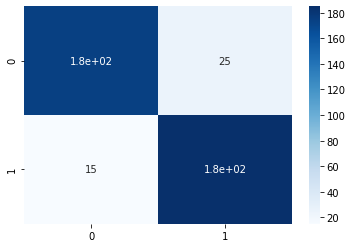

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, model.predict_classes(X_test))
sns.heatmap(cm, cmap='Blues', annot=True)

In [47]:
model.evaluate(X_test, y_test, verbose=1)

13/13 [==============================] - 1s 51ms/step - loss: 0.2954 - accuracy: 0.9000


[0.2953798770904541, 0.8999999761581421]

In [48]:
# evaluate the model
scores = model.evaluate(test_generator, steps=10, verbose=1)


10/10 [==============================] - 69s 7s/step - loss: 0.2141 - accuracy: 0.9187


In [49]:
print("%s: %f" % (model.metrics_names[0], scores[0]))
print("%s: %f" % (model.metrics_names[1], scores[1]))


loss: 0.214110
accuracy: 0.918750


In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model.predict(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, -1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.963


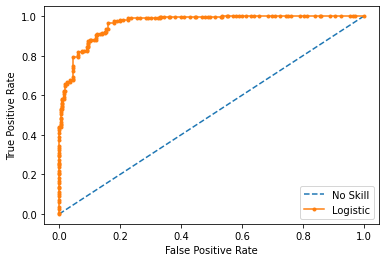

In [40]:
from matplotlib import pyplot

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [50]:
print(DATASET_DIR)

/content/gdrive/My Drive/data/corona_normal_bacterial/


In [51]:
# save model and architecture to single file
model.save(DATASET_DIR+ "/robustbacmodel.h5")
print("Saved model to disk")

Saved model to disk
